In [241]:
import cv2 

#img = cv2.imread('/home/likcos/DataSets/sportimages/sportimages/basket/basket2_0001.jpg')
#print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

# Convolutional Neural Networks

# Importar Librerías

In [242]:
import cv2 
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [243]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [244]:
dirname = os.path.join(os.getcwd(),'../DATASETS/FLORESJPEG')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  d:\Desktop\TrabajosIATec\ProyectosIaNicolas\../DATASETS/FLORESJPEG\
d:\Desktop\TrabajosIATec\ProyectosIaNicolas\../DATASETS/FLORESJPEG\CUNADEMOISES 1


d:\Desktop\TrabajosIATec\ProyectosIaNicolas\../DATASETS/FLORESJPEG\GIRASOL 1887
d:\Desktop\TrabajosIATec\ProyectosIaNicolas\../DATASETS/FLORESJPEG\MARGARITA 1961
d:\Desktop\TrabajosIATec\ProyectosIaNicolas\../DATASETS/FLORESJPEG\NOCHEBUENA 2183
d:\Desktop\TrabajosIATec\ProyectosIaNicolas\../DATASETS/FLORESJPEG\TULIPANES 1924
Directorios leidos: 5
Imagenes en cada directorio [1888, 1961, 2183, 1924, 2145]
suma Total de imagenes en subdirs: 10101


# Creamos las etiquetas

In [245]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  10101


In [246]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 CUNADEMOISES
1 GIRASOL
2 MARGARITA
3 NOCHEBUENA
4 TULIPANES


In [247]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [248]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (8080, 32, 32, 3) (8080,)
Testing data shape :  (2021, 32, 32, 3) (2021,)


Text(0.5, 1.0, 'Ground Truth : 2')

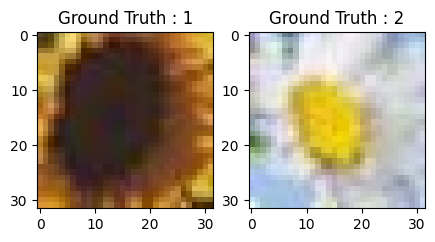

In [249]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

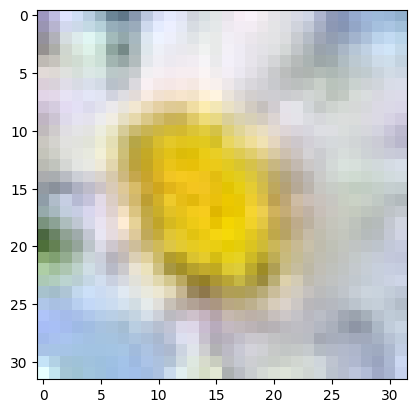

In [250]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [251]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 1
After conversion to one-hot: [0. 1. 0. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [252]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [253]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(6464, 32, 32, 3) (1616, 32, 32, 3) (6464, 5) (1616, 5)


# Creamos el modelo de CNN

In [254]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 55 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [255]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(5, 5),activation='linear',padding='same',input_shape=(32,32,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [256]:
sport_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 32)                262176    
                                                      

In [257]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [258]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/55


101/101 [==============================] - 4s 29ms/step - loss: 1.5916 - accuracy: 0.2215 - val_loss: 1.4740 - val_accuracy: 0.3298
Epoch 2/55
101/101 [==============================] - 3s 25ms/step - loss: 1.4601 - accuracy: 0.3224 - val_loss: 1.3424 - val_accuracy: 0.4845
Epoch 3/55
101/101 [==============================] - 3s 25ms/step - loss: 1.3528 - accuracy: 0.4175 - val_loss: 1.2006 - val_accuracy: 0.6479
Epoch 4/55
101/101 [==============================] - 3s 25ms/step - loss: 1.2408 - accuracy: 0.4896 - val_loss: 1.0729 - val_accuracy: 0.7562
Epoch 5/55
101/101 [==============================] - 3s 25ms/step - loss: 1.1565 - accuracy: 0.5339 - val_loss: 0.9677 - val_accuracy: 0.7871
Epoch 6/55
101/101 [==============================] - 2s 24ms/step - loss: 1.0812 - accuracy: 0.5724 - val_loss: 0.8788 - val_accuracy: 0.7946
Epoch 7/55
101/101 [==============================] - 2s 24ms/step - loss: 1.0204 - accuracy: 0.6046 - val_loss: 0.8005 - val_accuracy: 0.8094
Epoch 8/55

In [259]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("../ProyectosIaNicolas/clasFlores.h5py")

INFO:tensorflow:Assets written to: ../ProyectosIaNicolas/clasFlores.h5py\assets


INFO:tensorflow:Assets written to: ../ProyectosIaNicolas/clasFlores.h5py\assets


# Evaluamos la red

In [260]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

64/64 [==============================] - 0s 5ms/step - loss: 0.3121 - accuracy: 0.8902


In [261]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.3121386766433716
Test accuracy: 0.8901534080505371


In [262]:
sport_train.history

{'loss': [1.5916448831558228,
  1.4600698947906494,
  1.3527581691741943,
  1.240780234336853,
  1.1565357446670532,
  1.0812196731567383,
  1.020391583442688,
  0.955752432346344,
  0.9050273895263672,
  0.8483706712722778,
  0.8166901469230652,
  0.7752782106399536,
  0.7511627674102783,
  0.7323366403579712,
  0.7122612595558167,
  0.6941149830818176,
  0.682908296585083,
  0.6642489433288574,
  0.6401497721672058,
  0.6351372003555298,
  0.6256402134895325,
  0.6191665530204773,
  0.5965760946273804,
  0.5792092680931091,
  0.5729655623435974,
  0.5791224241256714,
  0.562680184841156,
  0.5566484928131104,
  0.5496515035629272,
  0.5468962788581848,
  0.5418967604637146,
  0.537568211555481,
  0.5321761965751648,
  0.5137178301811218,
  0.5085797309875488,
  0.5115829110145569,
  0.49875757098197937,
  0.5090745687484741,
  0.49551910161972046,
  0.49296459555625916,
  0.4892582893371582,
  0.4763545095920563,
  0.4844120442867279,
  0.48638010025024414,
  0.476636677980423,
  0.4

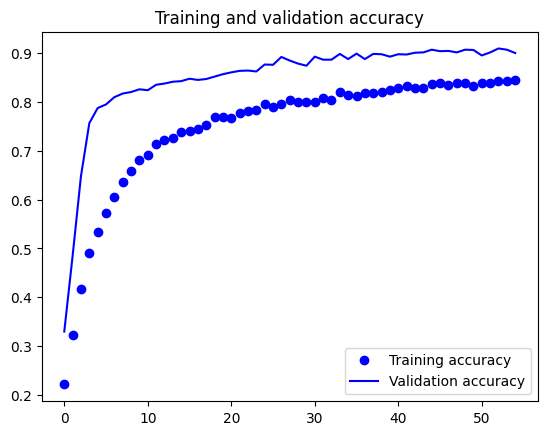

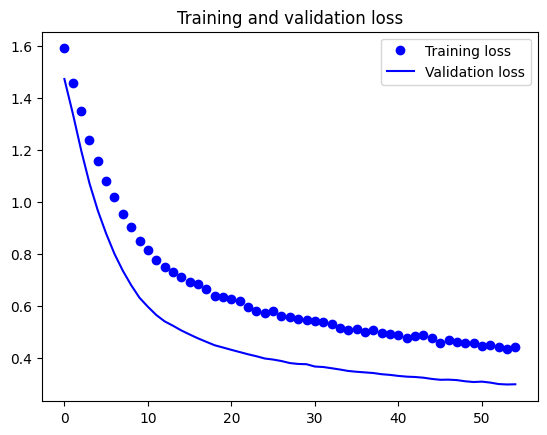

In [263]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [264]:
predicted_classes2 = sport_model.predict(test_X)

64/64 [==============================] - 0s 5ms/step


In [265]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [266]:
predicted_classes.shape, test_Y.shape

((2021,), (2021,))

# Aprendamos de los errores: Qué mejorar

Found 1799 correct labels


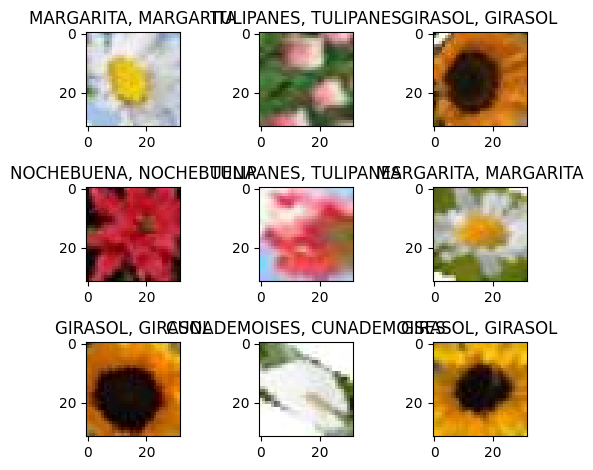

In [267]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 222 incorrect labels


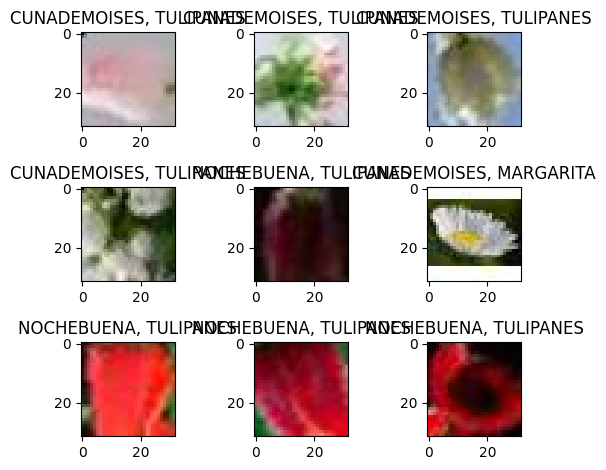

In [268]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]], deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [269]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.80      0.97      0.88       394
     Class 1       0.96      0.99      0.97       383
     Class 2       0.96      0.97      0.97       423
     Class 3       0.83      0.99      0.90       369
     Class 4       0.94      0.57      0.71       452

    accuracy                           0.89      2021
   macro avg       0.90      0.90      0.89      2021
weighted avg       0.90      0.89      0.88      2021

